<a href="https://colab.research.google.com/github/MRJG-99/PLASMA-MODEL/blob/main/Plasma_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

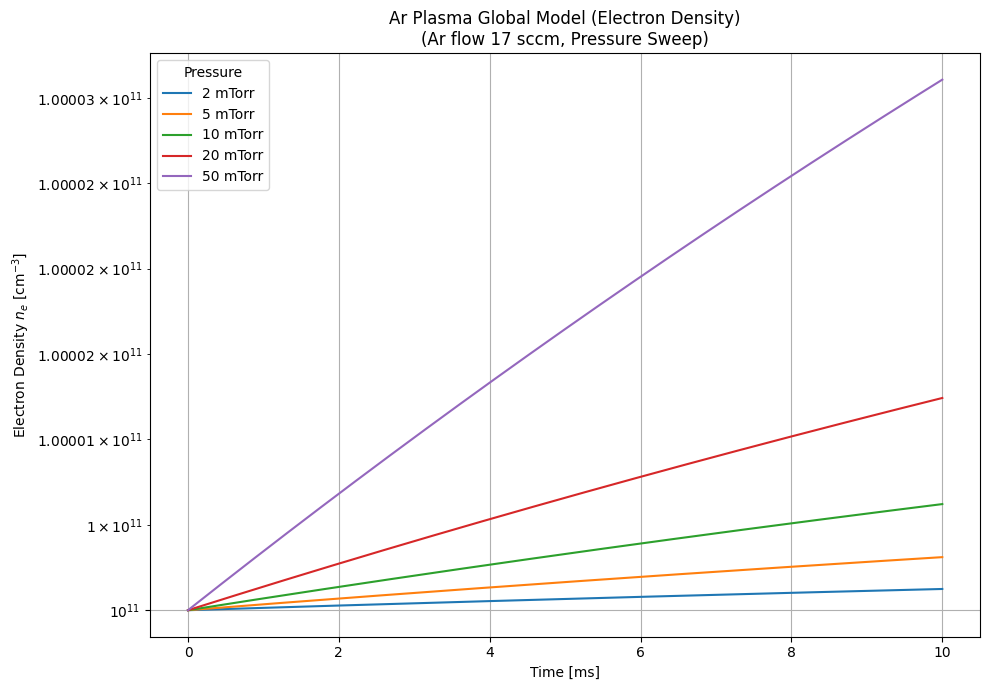

In [3]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import os

V = 1000
A = 600
T_gas = 293
P_abs = 300
Te = 3

pressures = [2, 5, 10, 20, 50]

k_B = 1.380649e-23
e_charge = 1.602e-19
Na = 6.022e23

def rate_coeff_ionization(Te):
    return 2.34e-14 * Te**0.5 * np.exp(-15.76/Te)

def n_Ar_from_pressure(P_mTorr, T_gas):
    P_Pa = P_mTorr * 1.33322 / 1000
    n = P_Pa / (k_B * T_gas)
    return n / 1e6

def wall_loss_coeff(D, L):
    return (np.pi**2 * D) / (L**2)

def global_model(t, y, nAr, k_ion, loss_coeff):
    ne, nArp = y
    S_ion = k_ion * ne * nAr
    L_wall = loss_coeff * nArp
    dne_dt = S_ion - L_wall
    dnArp_dt = S_ion - L_wall
    return [dne_dt, dnArp_dt]

os.makedirs('plots', exist_ok=True)
t_eval = np.linspace(0, 10e-3, 500)

plt.figure(figsize=(10,7))
for P in pressures:
    nAr = n_Ar_from_pressure(P, T_gas)
    k_ion = rate_coeff_ionization(Te)
    # 현실값 근사 위해 손실계수, 챔버길이, 확산계수 튜닝 (임의값)
    D = 1000 * (Te * e_charge) / (3 * 6.6e-19)
    L = 10
    loss_coeff = wall_loss_coeff(D, L)
    # 초기값을 실제 플라즈마 오더(10¹¹)로 설정
    y0 = [1e11, 0]
    sol = solve_ivp(global_model, [0, 10e-3], y0, t_eval=t_eval, args=(nAr, k_ion, loss_coeff))
    plt.plot(sol.t*1e3, sol.y[0], label=f'{P} mTorr')

plt.yscale('log')
plt.xlabel('Time [ms]')
plt.ylabel('Electron Density $n_e$ [cm$^{-3}$]')
plt.title('Ar Plasma Global Model (Electron Density)\n(Ar flow 17 sccm, Pressure Sweep)')
plt.legend(title='Pressure')
plt.grid(True)
plt.tight_layout()
plt.savefig('plots/electron_density_vs_time_v2.png')
plt.show()
